# Dask Implementation

In [29]:
import numpy as np
import pandas as pd
import time
import dask
import dask.dataframe as dd
import matplotlib.pyplot as plt
from dask.distributed import Client
import joblib
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import LinearSVC

SEED = 42

In [2]:
client = Client('172.31.88.97:8786')
client = client.restart()
print(client)

<Client: 'tcp://172.31.88.97:8786' processes=0 threads=0, memory=0 B>


## Read data

In [3]:
# Split data into X and y
X_reg_train = pd.read_csv('../data/X_reg_train.csv')
X_reg_test = pd.read_csv('../data/X_reg_test.csv')

X_class_train = pd.read_csv('../data/X_class_train.csv')
X_class_test = pd.read_csv('../data/X_class_test.csv')

y_reg_train = pd.read_csv('../data/y_reg_train.csv')
y_reg_test = pd.read_csv('../data/y_reg_test.csv')

y_class_train = pd.read_csv('../data/y_class_train.csv')
y_class_test = pd.read_csv('../data/y_class_test.csv')

In [8]:
X_reg_test.shape

(4000000, 5)

## Dask Experiment Function

In [47]:
def dask_time_algorithm(subset_prop, algorithm_name, SEED=SEED):
    '''
    algorithm_name one of 'KNN', 'RF', 'KMEANS'
    '''
    if (algorithm_name == "KNN" or algorithm_name == "RF"):
        X_reg_train_subset = X_reg_train.head(int(len(X_reg_train) * subset_prop))
        X_reg_test_subset = X_reg_test.head(int(len(X_reg_test) * subset_prop))
        y_reg_train_subset = y_reg_train.head(int(len(y_reg_train) * subset_prop))
        y_reg_test_subset = y_reg_test.head(int(len(y_reg_test) * subset_prop))

        print(f'X_reg_train_subset shape {X_reg_train_subset.shape}')
        print(f'X_reg_test_subset shape {X_reg_test_subset.shape}')
        print(f'y_reg_train_subset shape {y_reg_train_subset.shape}')
        print(f'y_reg_test_subset shape {y_reg_test_subset.shape}')
       
    elif (algorithm_name == "KMEANS"):
        X_class_train_subset = X_class_train.head(int(len(X_class_train) * subset_prop))
        X_class_test_subset = X_class_test.head(int(len(X_class_test) * subset_prop))
        y_class_train_subset = y_class_train.head(int(len(y_class_train) * subset_prop))
        y_class_test_subset = y_class_test.head(int(len(y_class_test) * subset_prop))
       
    start_time = time.time()
       
    if algorithm_name == "KNN":
        with joblib.parallel_backend('dask'):
            knn_model = KNeighborsRegressor(n_neighbors=5)
            knn_model.fit(X_reg_train_subset, y_reg_train_subset)
            metric = knn_model.score(X_reg_test_subset, y_reg_test_subset) # metric is KNN accuracy
                       
    elif algorithm_name == "KMEANS":
        with joblib.parallel_backend('dask'):
            kmeans_model = KMeans(n_clusters=2, random_state=SEED, n_init="auto")
            kmeans_model.fit(X_class_train_subset)
            metric = None # No performance metric for KMEANS (unsupervised)
           
    elif algorithm_name == "RF":
        with joblib.parallel_backend('dask'):
            rf_model = RandomForestRegressor(max_depth=2, random_state=SEED)
            rf_model.fit(X_reg_train_subset, y_reg_train_subset)
            y_pred = rf_model.predict(X_reg_test_subset)
            metric = mean_squared_error(y_reg_test_subset, y_pred) # metric is random forest MSE
           
    end_time = time.time()
    time_delta = end_time - start_time
    return time_delta, metric

## Set proportions to loop over

In [ ]:
props = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

## KNN Test

In [16]:
knn_times = []
knn_metrics = []

for prop in props:
    print(prop)
    runtime, metric = dask_time_algorithm(prop, algorithm_name="KNN")
    knn_times.append(runtime)
    knn_metrics.append(metric)
   
print(knn_times)
print(knn_metrics)

0.1
X_reg_train_subset shape (1600000, 5)
X_reg_test_subset shape (400000, 5)
y_reg_train_subset shape (1600000, 2)
y_reg_test_subset shape (400000, 2)
0.2
X_reg_train_subset shape (3200000, 5)
X_reg_test_subset shape (800000, 5)
y_reg_train_subset shape (3200000, 2)
y_reg_test_subset shape (800000, 2)
0.3
X_reg_train_subset shape (4800000, 5)
X_reg_test_subset shape (1200000, 5)
y_reg_train_subset shape (4800000, 2)
y_reg_test_subset shape (1200000, 2)
0.4
X_reg_train_subset shape (6400000, 5)
X_reg_test_subset shape (1600000, 5)
y_reg_train_subset shape (6400000, 2)
y_reg_test_subset shape (1600000, 2)
0.5
X_reg_train_subset shape (8000000, 5)
X_reg_test_subset shape (2000000, 5)
y_reg_train_subset shape (8000000, 2)
y_reg_test_subset shape (2000000, 2)
0.6
X_reg_train_subset shape (9600000, 5)
X_reg_test_subset shape (2400000, 5)
y_reg_train_subset shape (9600000, 2)
y_reg_test_subset shape (2400000, 2)
0.7
X_reg_train_subset shape (11200000, 5)
X_reg_test_subset shape (2800000, 5)


In [28]:
knn_frame = pd.DataFrame(list(zip(knn_times, knn_metrics)), columns=['Time', 'Metric'], index=props)
knn_frame.head()

,Time,Metric
0.1,7.294049,0.570870
0.2,15.398858,0.633325
0.3,25.114567,0.677940
0.4,35.889736,0.712708
0.5,46.067537,0.739126


Text(0, 0.5, 'Time (s)')

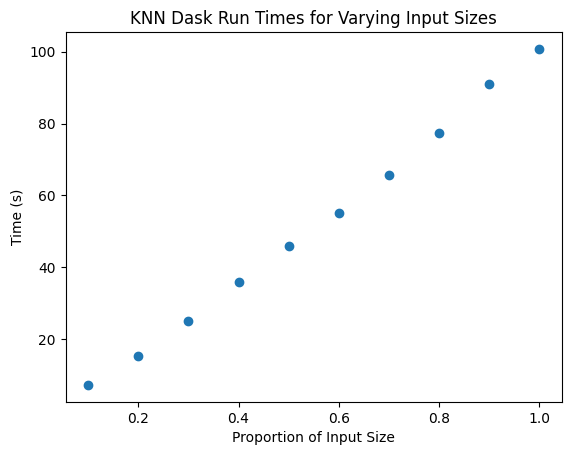

In [35]:
plt.scatter(x=knn_frame.index, y=knn_frame['Time'])
plt.title('KNN Dask Run Times for Varying Input Sizes')
plt.xlabel('Proportion of Input Size')
plt.ylabel('Time (s)')

In [37]:
knn_frame.to_csv('dask_knn_results.csv', index=True)

## KMeans Test

In [42]:
kmeans_times = []
kmeans_metrics = []

for prop in props:
    print(prop)
    runtime, metric = dask_time_algorithm(prop, algorithm_name="KMEANS")
    kmeans_times.append(runtime)
    kmeans_metrics.append(metric)
   
print(kmeans_times)
print(kmeans_metrics)

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
[1.0086541175842285, 2.181875705718994, 3.315666913986206, 4.3873610496521, 3.910090923309326, 7.189364433288574, 6.380413770675659, 8.560649394989014, 9.469146013259888, 8.998127222061157]
[None, None, None, None, None, None, None, None, None, None]


In [43]:
kmeans_frame = pd.DataFrame(list(zip(kmeans_times, kmeans_metrics)), columns=['Time', 'Metric'], index=props)
kmeans_frame.head()

,Time,Metric
0.1,1.008654,None
0.2,2.181876,None
0.3,3.315667,None
0.4,4.387361,None
0.5,3.910091,None


Text(0, 0.5, 'Time (s)')

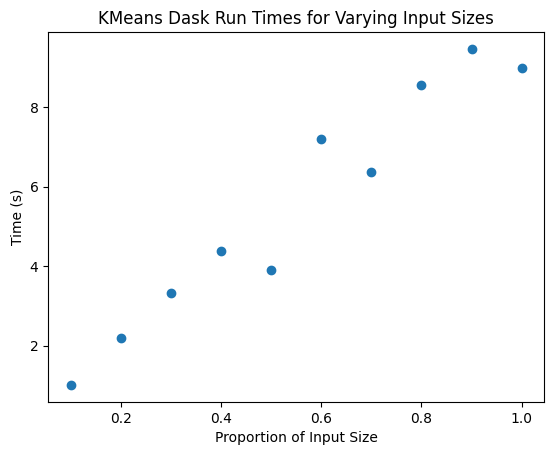

In [44]:
plt.scatter(x=kmeans_frame.index, y=kmeans_frame['Time'])
plt.title('KMeans Dask Run Times for Varying Input Sizes')
plt.xlabel('Proportion of Input Size')
plt.ylabel('Time (s)')

In [45]:
kmeans_frame.to_csv('dask_kmeans_results.csv', index=True)

## Random Forest Test

In [48]:
rf_times = []
rf_metrics = []

for prop in props:
    print(prop)
    runtime, metric = dask_time_algorithm(prop, algorithm_name="RF")
    rf_times.append(runtime)
    rf_metrics.append(metric)
   
print(rf_times)
print(rf_metrics)

0.1
X_reg_train_subset shape (1600000, 5)
X_reg_test_subset shape (400000, 5)
y_reg_train_subset shape (1600000, 2)
y_reg_test_subset shape (400000, 2)
0.2
X_reg_train_subset shape (3200000, 5)
X_reg_test_subset shape (800000, 5)
y_reg_train_subset shape (3200000, 2)
y_reg_test_subset shape (800000, 2)
0.3
X_reg_train_subset shape (4800000, 5)
X_reg_test_subset shape (1200000, 5)
y_reg_train_subset shape (4800000, 2)
y_reg_test_subset shape (1200000, 2)
0.4
X_reg_train_subset shape (6400000, 5)
X_reg_test_subset shape (1600000, 5)
y_reg_train_subset shape (6400000, 2)
y_reg_test_subset shape (1600000, 2)
0.5
X_reg_train_subset shape (8000000, 5)
X_reg_test_subset shape (2000000, 5)
y_reg_train_subset shape (8000000, 2)
y_reg_test_subset shape (2000000, 2)
0.6
X_reg_train_subset shape (9600000, 5)
X_reg_test_subset shape (2400000, 5)
y_reg_train_subset shape (9600000, 2)
y_reg_test_subset shape (2400000, 2)
0.7
X_reg_train_subset shape (11200000, 5)
X_reg_test_subset shape (2800000, 5)


In [49]:
rf_frame = pd.DataFrame(list(zip(rf_times, rf_metrics)), columns=['Time', 'Metric'], index=props)
rf_frame.head()

,Time,Metric
0.1,43.093861,4.034832e+12
0.2,90.430914,4.032501e+12
0.3,133.869818,4.040529e+12
0.4,176.258684,4.041523e+12
0.5,217.591541,4.043357e+12


Text(0, 0.5, 'Time (s)')

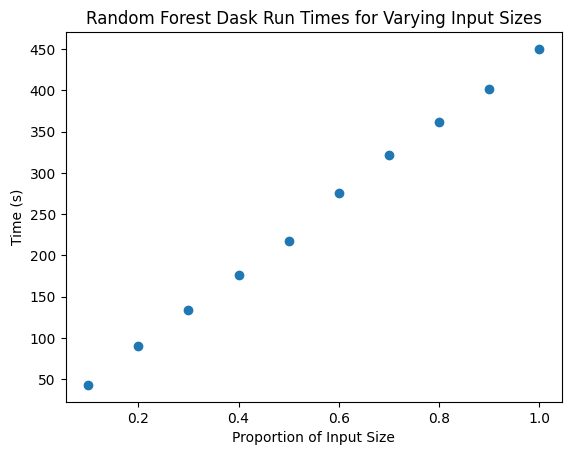

In [50]:
plt.scatter(x=rf_frame.index, y=rf_frame['Time'])
plt.title('Random Forest Dask Run Times for Varying Input Sizes')
plt.xlabel('Proportion of Input Size')
plt.ylabel('Time (s)')

In [51]:
rf_frame.to_csv('dask_rf_results.csv', index=True)